# 학습 목표

---

- 딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라 해봅니다.

# 학습 내용

---

- 셸로우 포커스 만들기 (1) 사진을 준비하자
- 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기
- 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기
- 셸로우 포커스 만들기 (4) 배경 흐리게 하기
- 셸로우 포커스 만들기 (5) 흐린 배경과 원본 영상 합성

In [3]:
# LMS 환경에서 데이터 준비
!mkdir -p ~/aiffel/human_segmentation/models
!mkdir -p ~/aiffel/human_segmentation/images
!ln -s ~/data/* ~/aiffel/human_segmentation/images

ln: failed to create symbolic link '/aiffel/aiffel/human_segmentation/images/my_image.png': File exists


In [4]:
!tree

.
├── images
│   └── my_image.png -> /aiffel/data/my_image.png
├── models
├── Segmentation_Practice.ipynb
└── Segmentation_project.ipynb

2 directories, 3 files


# 셸로우 포커스 만드는 방법

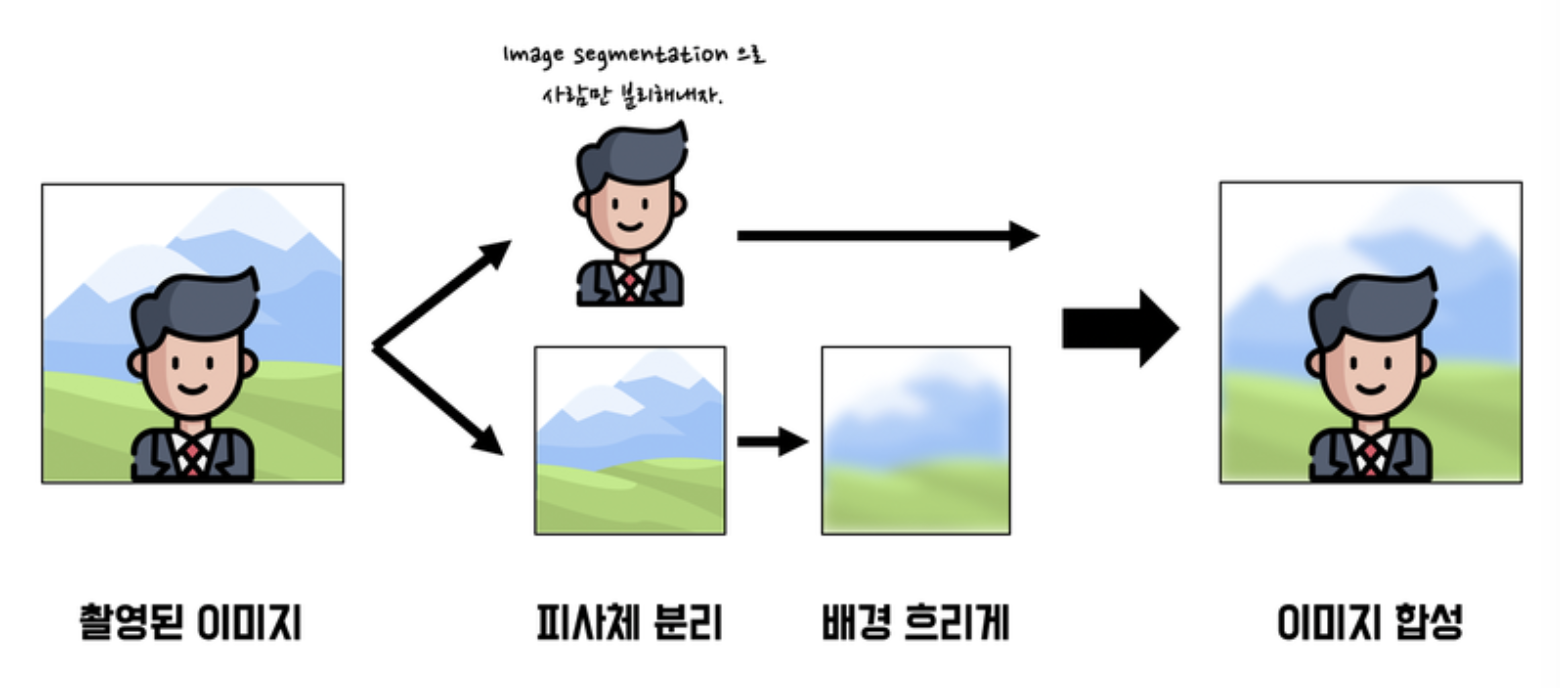

두 개의 렌즈가 맡은 역할을 하나의 렌즈에서 구현해야 합니다. 이미지 세그멘테이션(image segmentation) 기술을 이용하면 하나의 이미지에서 배경과 사람을 분리할 수 있습니다. 분리된 배경을 블러(blur) 처리 후 사람 이미지와 다시 합하면 아웃포커싱 효과를 적용한 인물 사진을 얻을 수 있습니다.

따라서 우리는 다음과 같은 후가공으로 '인물사진 모드'인 사진을 만들 겁니다.

>    1. 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
   2. 시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
   3.    블러링(blurring) 기술로 배경을 흐리게 합니다.
   4.  피사체를 배경의 원래 위치에 합성합니다.


## (1) 사진을 준비하자

In [6]:
### 라이브러리 불러오기

- urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
- pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
- pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리

In [7]:
import os
import urllib # web에서 데이터 다운로드
import cv2 # OpenCV를 통해 이미지 처리
import numpy as np 
from pixellib.semantic import semantic_segmentation # 이번 모델
from matplotlib import pyplot as plt

### 준비 한 이미지 읽기

- os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 img_path에 저장
- 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
- cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장


(500, 892, 3)


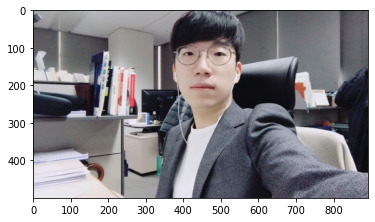

In [9]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## (2) 세그멘테이션으로 사람 분리하기

배경에 렌즈 흐림 효과를 위해 이미지에서 사람과 피사체를 분리해야 함
- 인물 사진에서 배경만 다르게 편집하려는 용도

### 이미지 세그멘테이션(Segmentation)이란 ?

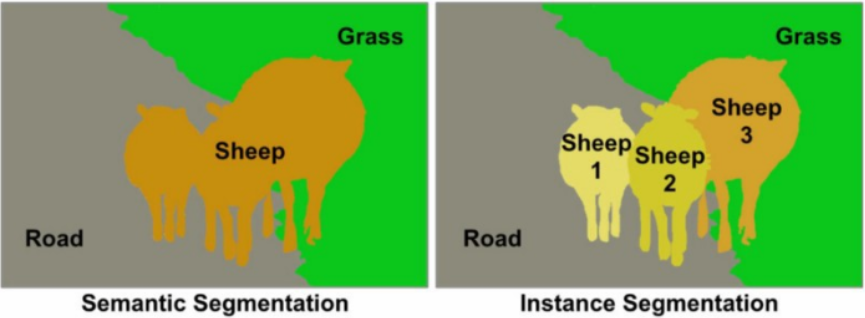

- 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법
- 모든 픽셀에 라벨(label)을 할당하고, 라벨이 같은 객체들은 "공통적인 특징"을 가진다고 가정
- 공통 특징은 물리적 의미가 없을 수도 있음. 
    - 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있다. 
- 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출한다.

#### 시맨틱 세그멘테이션(semantic segmentation)이란?

- 우리가 인식하는 세계처럼 물리적 의미 단위로 인식. 
    - 쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)
    
- 시맨틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출. 
    - 그래서 사람이 누구인지 관계없이 같은 라벨로 표현

#### 인스턴스 세그멘테이션(Instance segmentation)이란?
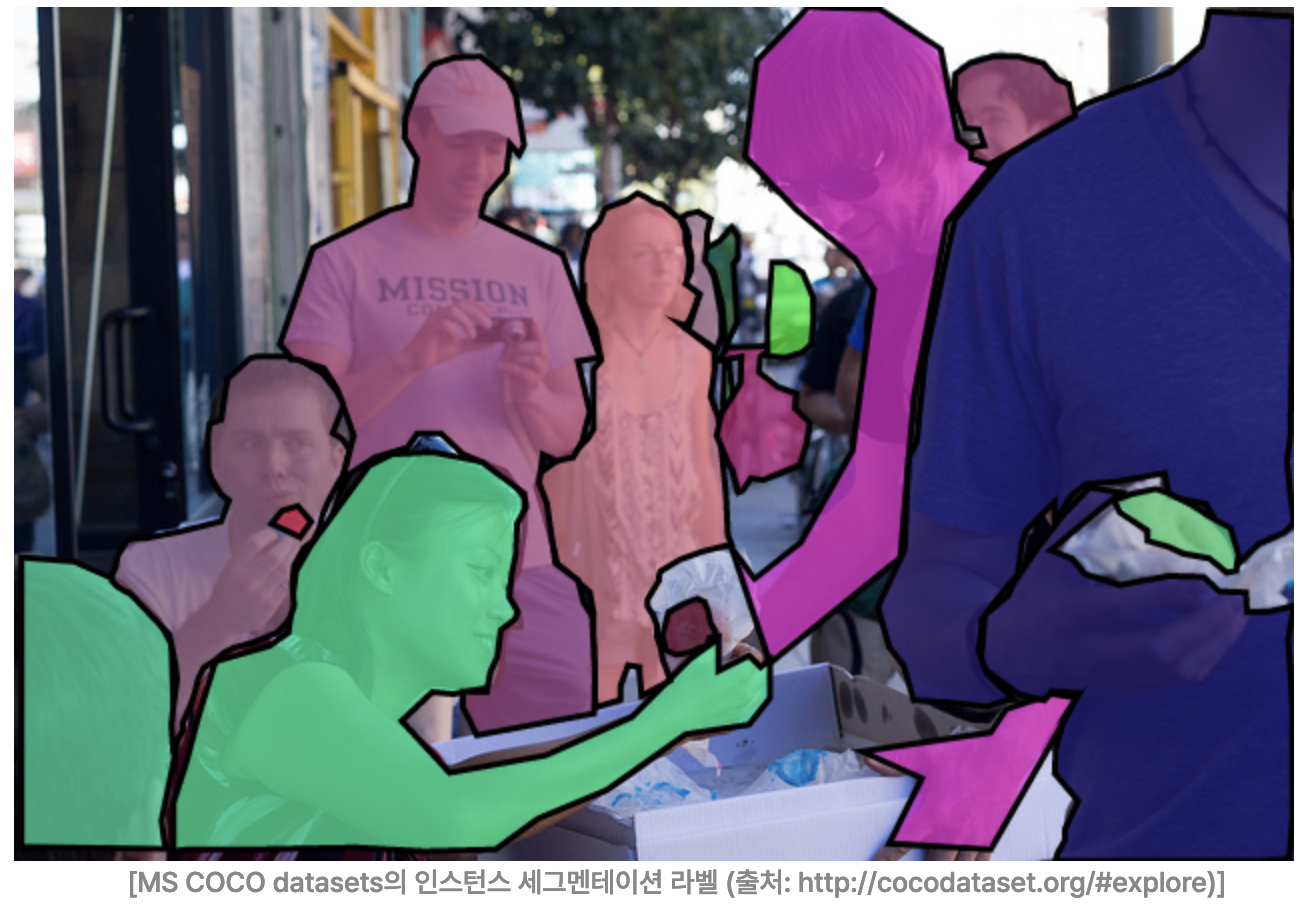

- 인스턴스 세그멘테이션은 사람 개개인별로 다른 라벨을 가지게 함. 
    - 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식.



#### 워터쉐드 세그멘테이션(watershed segmentation)

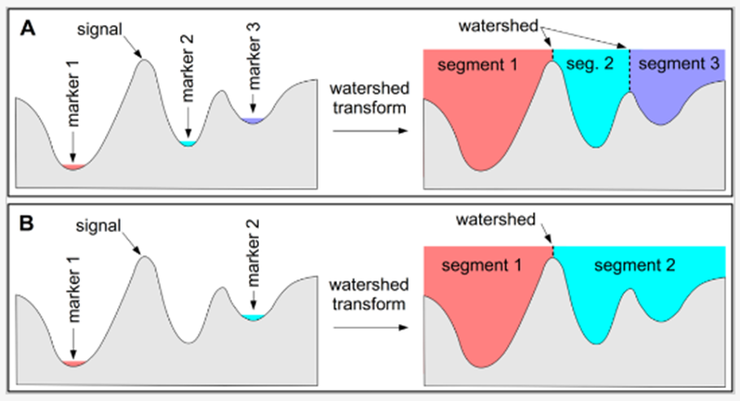
- 이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 '경계'를 나누는 것. 

- 이미지는 그레이스케일(grayscale)로 변환하면 0~255의 값을 가지게 되고, 픽셀 값을 이용해서 각 위치의 높고 낮음을 구분할 수 있음. 
- 낮은 부분부터 서서히 '물'을 채워 나간다고 생각하면 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생기게 되고, 그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있다.

## (3) 시맨틱 세그멘테이션 다뤄보기 - 개념정리

세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용됨. 
이번 실습은 DeepLab이라는 세그멘테이션 모델을 이용
- DeepLab 알고리즘(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있음

    [DeepLab V3+: Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://bloglunit.wordpress.com/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/)


- V1 : Atrous Convolution을 적용
- V2 : Multi-scale Context적용을 위한 ASPP 기법 제안
    - ASPP : Atrous Spatial Pyramid Pooling
- V3 : ResNet 구조에 Atrous Convolution를 활용하여, 더 dense한 feature map얻는 방법 제안
- V3+ : Atrous Convolution와 Separable Convolution을 결합한 Atrous Separable Convolution 제안
    * Xception : Depthwise Separable Convolution이 처음 제시된 논문

### Atrous convolution [출처](https://www.mdpi.com/2072-4292/9/5/498) 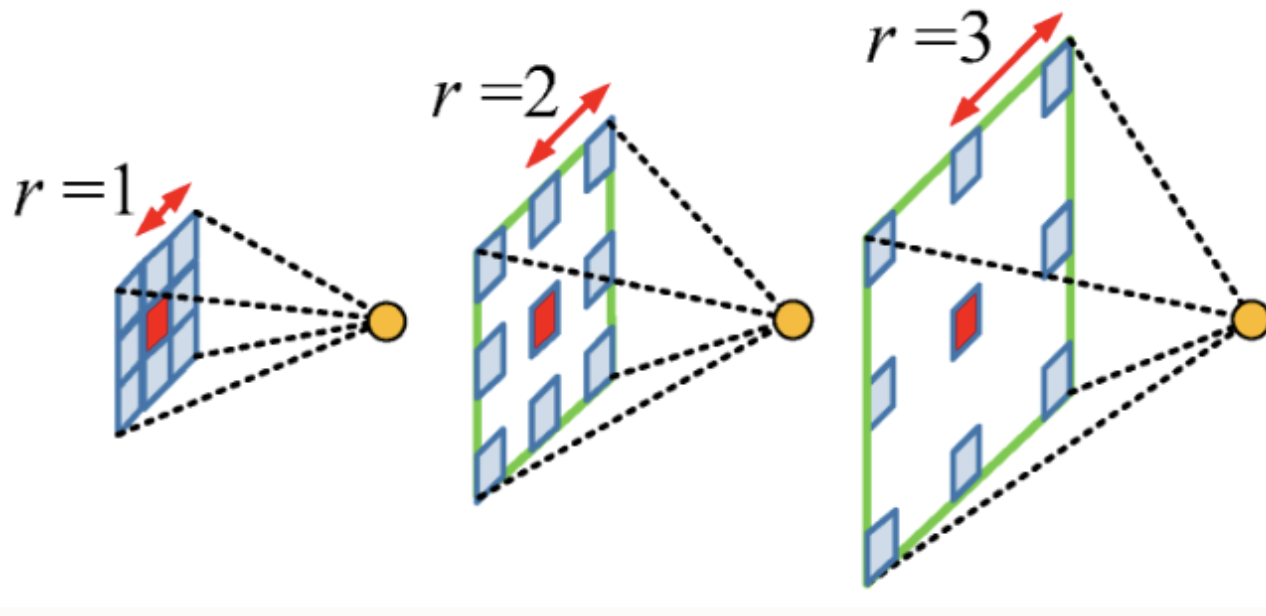

- 기존 convolution과 다르게, 필터 내부에 빈 공간을 둔 채로 작동
    - 위 예시에서, 얼마나 빈 공간을 둘 지 결정하는 파라미터인 rate r=1일 경우, 기존 convolution과 동일, r이 커질 수록, 빈 공간이 넓어지게 된다.

장점 : 
- 연산량을 유지하면서도, 한 픽셀이 볼 수 있는 영역을 크게 가져감. 
    - 보통 semantic segmentation에서 높은 성능을 내기 위해서는 convolutional neural network의 마지막에 존재하는 한 픽셀이 입력값에서 어느 크기의 영역을 커버할 수 있는지를 결정하는 receptive field 크기가 중요하게 작용한다. 
- 파라미터 수를 늘리지 않으면서도 receptive field를 크게 키울 수 있다.

### ASPP

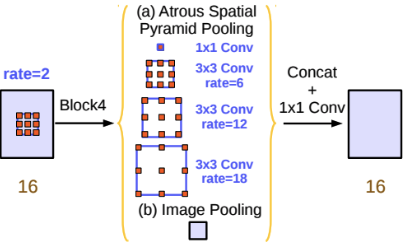

- Feature map으로부터 여러개의 rate가 다른 Atrous convolution을 병렬 적용 후 합치는 기법, multi-scale context를 모델 구조로 구현하여 정확도 향상
- Receptive Field를 넓게 사용하기 위해(적은 파라미터로 필터가 더 넓은 영역을 볼 수 있다.)

### U-Net

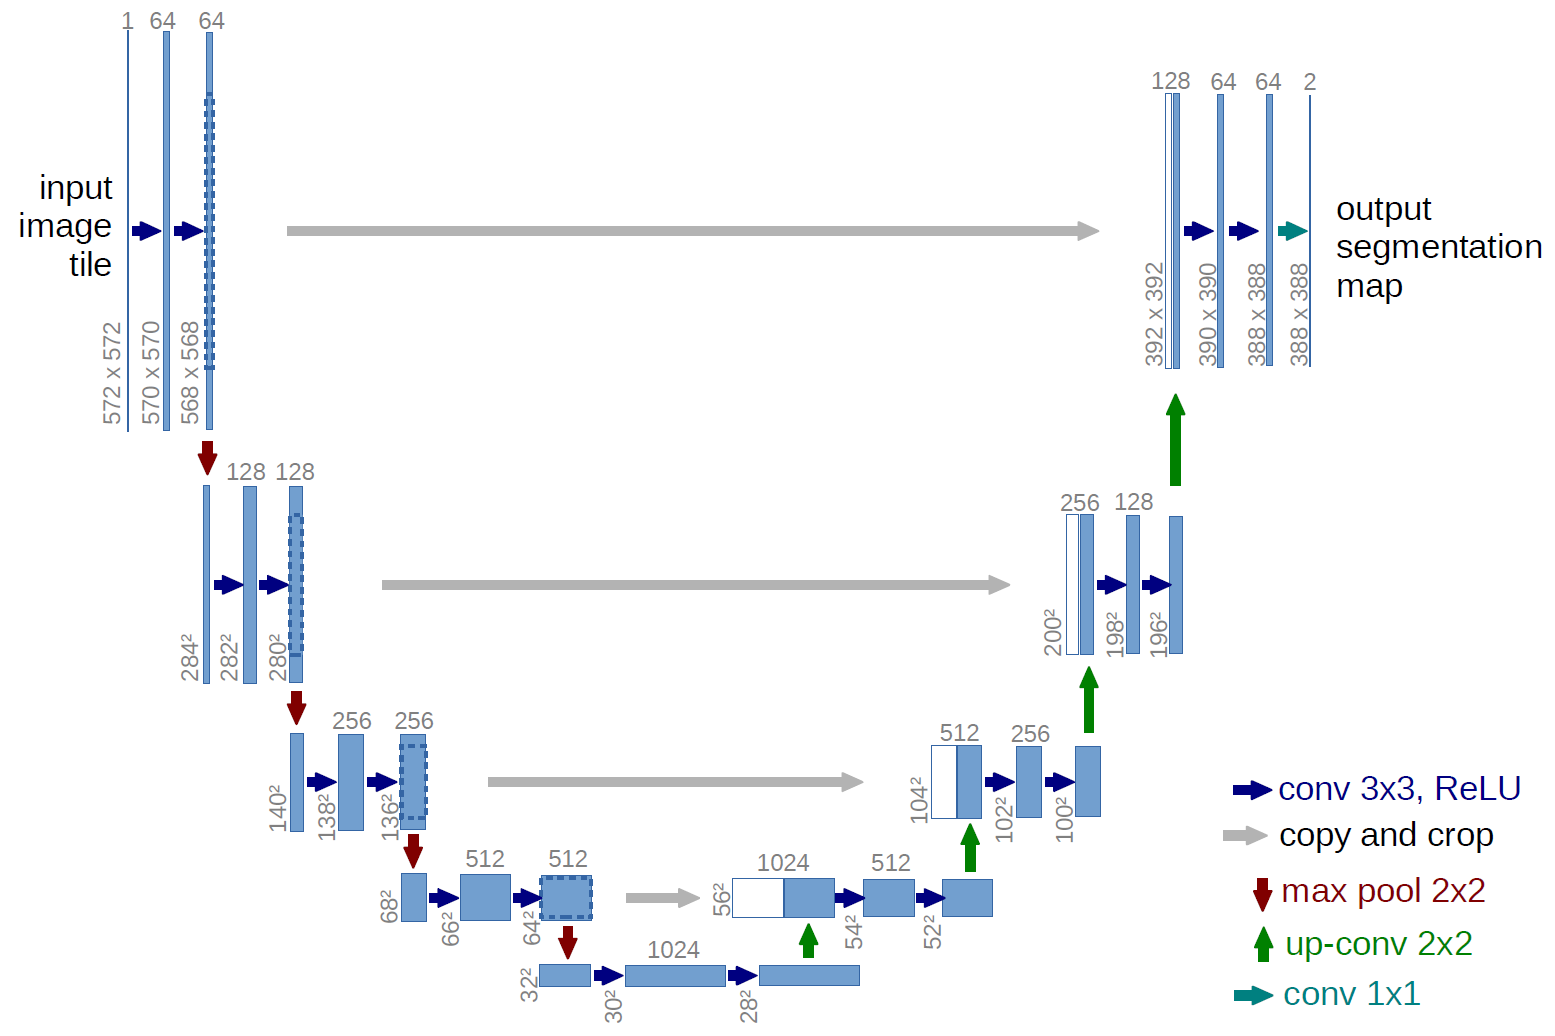

- Encoder-decoder 구조로 CNN이 이뤄져 있음
- Skip Connection을 활용하여, Decoder에서 Encoder의 동일한 크기를 가진 Feature Map 정보를 가져와서 더 정확한 Boundary Segmentation이 가능하게 함

### Skip Connection
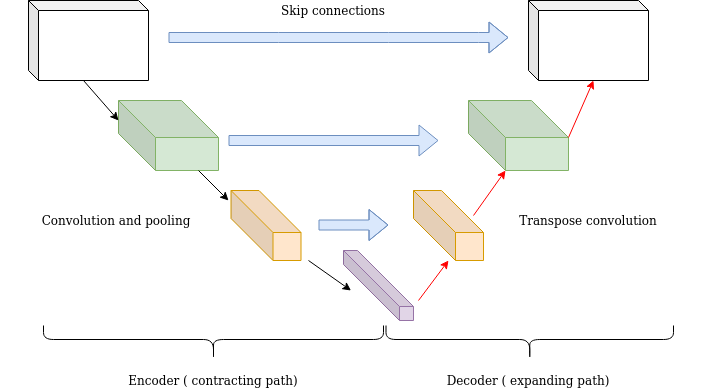
- 하나의 layer의 output을 몇 개의 layer를 건너뛰고 다음 layer의 input에 추가하는 것
- Decoder에서 정보 회복 시에 latent space에 구조적인 정보 위주로 집중되어 있어, 상대적으로 부족한 detail를 Feature Map을 통해 제공

## (3) 시맨틱 세그멘테이션 다뤄보기 - 실습코드

### PixelLib 제공 모델(DeepLab) 다운로드
- PixelLib : 사진과 영상의 세그멘테이션 task를 할 수 있도록 제공 된 라이브러리

In [10]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. 
# model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 
# "/aiffel/aiffel/human_segmentation/models/
# /deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장

# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
# urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 
# 있는 파일을 다운로드 해서 model_file 파일명으로 저장
urllib.request.urlretrieve(model_url, model_file) 

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f4144eb8ac0>)

In [11]:
!tree # 저장된 모델 확인

.
├── images
│   └── my_image.png -> /aiffel/data/my_image.png
├── models
│   └── deeplabv3_xception_tf_dim_ordering_tf_kernels.h5
├── Segmentation_Practice.ipynb
└── Segmentation_project.ipynb

2 directories, 4 files


In [12]:
# PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic
# segmentation을 수행하는 클래스 인스턴스를 만듬
model = semantic_segmentation()
# pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
model.load_pascalvoc_model(model_file) 

In [13]:
# segmentAsPascalvoc()함수를 호출 하여 입력된 이미지를 분할,
# 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

# PascalVoc 데이터로 학습된 모델
segvalues, output = model.segmentAsPascalvoc(img_path) 

### [Pascal Voc Datasets](http://host.robots.ox.ac.uk/pascal/VOC/)
- 20 Classes
- 11530 images, with containing 27,450 ROI(Room Of Intereset) annotated objects, 6929 Segmentations.



In [14]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES) # background제외, 20개의 클래스가 있다.

21

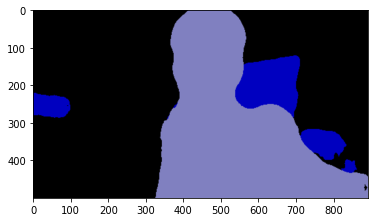

In [15]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 
# output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [16]:
# segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 
# 배열값을 출력
segvalues 

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [17]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


- output : 세그멘테이션 결과가 각기 다른 색상으로 담겨있다.
- segvalues : class_ids, masks가 있고, `class_ids`를 통해 어떤 물체가 있는 지 확인이 가능하다.

In [18]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [21]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

In [28]:
 # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

seg_color = (128,128,192) # 15번 레이블의 칼라를 BGR순으로 변경한 값

(500, 892)


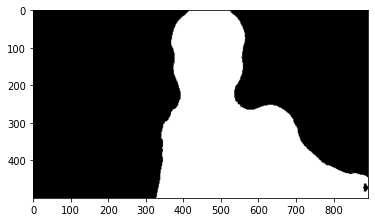

In [24]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

- 채널 정보가 사라짐, 물체의 위치 1, 없으면 0

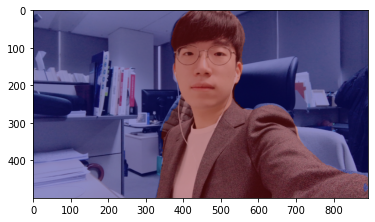

In [25]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## (4) 배경 흐리게 하기

### `blur()` 사용하기

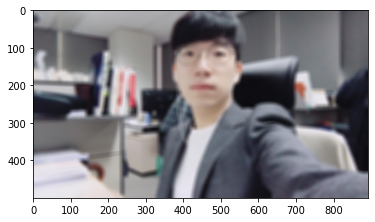

In [26]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

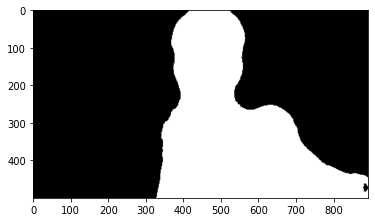

In [29]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
# 배경이 0(Black), 사람이 255(White) (At grayscale)
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)     

plt.imshow(cv2.cvtColor(img_mask_color, cv2.COLOR_BGR2RGB))
plt.show()

In [32]:
img_mask.shape, img_mask_color.shape

((500, 892), (500, 892, 3))

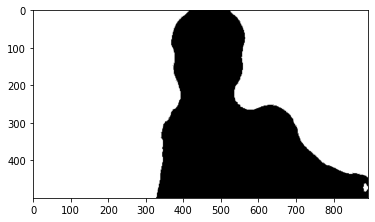

In [33]:
# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나

# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)
plt.imshow(cv2.cvtColor(img_bg_mask, cv2.COLOR_BGR2RGB))
plt.show()

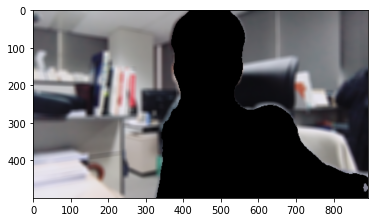

In [34]:
# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- bitwise_not 함수를 이용하면 이미지가 반전. 
원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 된다. 

- 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있다. 
0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 된다.

## (5) 흐린 배경과 원본 영상 합성

### `np.where()` 활용해서, 합치기

> `img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)`
흰색(255)이 때 original, 아닐 때 blur

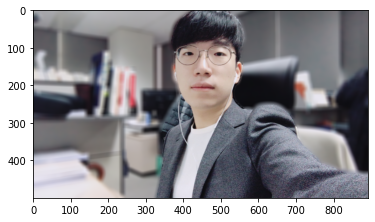

In [35]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

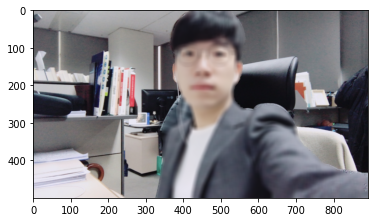

In [37]:
# Q. 이번에는 사람 부분을 블러로, 배경 부분을 원본으로 출력해볼까요?
# 힌트 : img_mask_color 옵션을 적절히 조정해주고, img_orig, img_orig_blur 를 활용하세요.
img_concat = np.where(img_mask_color==0, img_orig, img_orig_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()